# Model Evaluations
The purpose of this notebook is to report the actual accuracy of the three approaches. To do so, four new data points from October 2021 for each series supplied by the Hobby and IAH airports are compared to the forecasted values. Originally, the authors didn't have access to these new values when building the modeling approach and were pleased to find the accuracy and results were very good in most instances. Had ARIMA only been employed as the modeling strategy, using additive outliers identified from X13 only, the accuracy would have been the highest than from any other approach. However, using a mixed modeling approach where the best model was automatically selected based on test MAPE values, the accuracy using the unadjusted data approach was the best and led to close to or greater than 95% accuracy on all series.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

sns.set(rc={'figure.figsize':(14,7)})
series_map = pickle.load(open('pickled/series_map.pckl','rb'))
approach_map = {
    'Unadjusted':'orig',
    'IgnoreCOVID':'no_covid',
    'OutlierDetect':'with_outlier_detection'
}

pd.options.display.float_format = '{:,.0f}'.format

In [2]:
future_actuals = pd.read_csv('data/Future Passengers.csv',parse_dates=['DATE'])
future_actuals.set_index('DATE').astype(float)

,HOU-Int,HOU-Dom,IAH-Dom,IAH-Int
DATE,,,,
2021-10-01,"27,153","498,237","1,375,815","285,498"
2021-11-01,"34,242","495,800","1,356,136","336,156"
2021-12-01,"39,101","477,752","1,331,893","417,561"
2022-01-01,"29,084","387,446","1,036,051","287,998"


In [3]:
def compare_all_models(series_map,accuracy='total',models='best'):
    """ outputs a matrix showing each approach for each series and either a total accuracy (defined as the total passengers predicted compared to the total passengers),
    a monthly average accuracy (defined as the average accuracy per month of passengers predicted vs. actual passengers),
    or the selected best models if models == 'best'
    
    Args:
        series_map (Dict[str:any]): the map of the different series name whose keys to match the output saved csv names from previous notebooks 
        accuracy (str): one of 'total', 'mean', default 'total' - the type of accuracy desired (defined in function docstring above)
        models (str): default 'best' - the models to compare, must be 'best' or a model type previously evluated (like 'arima')
    
    Returns:
        (array(DataFrame, DataFrame) or DataFrame): a dataframe with accuracy results + 1 with models if models == 'best' else a dataframe with accuracy results only
    """
    all_results = pd.DataFrame(columns=approach_map.keys(),index=series_map.keys())
    all_best_models = all_results.copy()
    for series in series_map.keys():
        for apprt, appr in approach_map.items():
            results = pd.read_excel(os.path.join('fcst_results',
                                       '{}_series_{}_results.xlsx'.format(appr,series)),
                                       sheet_name=['lvl_fcsts','model_summaries'])
            
            if models == 'best':
                best_model = results['model_summaries'].iloc[0,0]
            else:
                best_model = models
            
            results_lvl = results['lvl_fcsts']
            results_lvl['DATE'] = pd.to_datetime(results_lvl['DATE'])
            results_lvl = results_lvl.loc[results_lvl['DATE'].isin(future_actuals['DATE'])].reset_index(drop=True)
            try:
                if accuracy == 'total':
                    all_results.loc[series,apprt] = 1 - np.abs((future_actuals[series].sum() - results_lvl[best_model].sum()) / future_actuals[series].sum())
                elif accuracy == 'mean':
                    all_results.loc[series,apprt] = 1 - np.mean(np.abs((future_actuals[series] - results_lvl[best_model]) / future_actuals[series]))
                else:
                    raise ValueError(f'was expecting accuracy to be one of "total", "mean", got {accuracy}')
            except KeyError:
                pass
            if models == 'best':
                all_best_models.loc[series,apprt] = best_model
    
    all_results.loc['Grand Mean'] = all_results.mean()
    if models == 'best':
        return all_results, all_best_models
    else:
        return all_results.dropna(axis=1)

def display_results_hm(tbl,t='Total',models='Best Models'):
    """ displays the results of an accuracy matrix in a heatmap
    
    Args:
        tbl (DataFrame): the matrix with accuracies of series by approach, last row is "grand mean"
        t (str): default 'Total' - for the plot title - currently uses 'Total' or 'Monthly Average'
        models (str): default 'Best Models' - also in the title, like 'Best Models', 'ARIMA', or something like that
        
    Returns:
        (DataFrame): the last row of the accuracy matrix from the tbl arg, also plots the heatmap
    """
    sns.heatmap(tbl.iloc[:-1].astype(float),
               vmin=.5,
               vmax=1,
               annot=True,
               fmt='.2%',
               cmap=sns.color_palette("Spectral", as_cmap=True),
               linewidth=2)
    plt.title(f"Different Approaches' {t} Accuracy on New Data - {models}",size=18)
    plt.yticks(rotation = 0,size=16)
    plt.xticks(size=16)
    plt.show()
    return tbl.iloc[-1:,:]

## Compare all best models

### selected best models

In [4]:
pd.options.display.float_format = '{:.2%}'.format
best_models_results = compare_all_models(series_map)
best_models_results[1]

,Unadjusted,IgnoreCOVID,OutlierDetect
IAH-Dom,weighted_ensemble,arima,prophet
IAH-Int,arima,prophet,arima
HOU-Dom,arima,weighted_ensemble,arima
HOU-Int,arima,lstm_reg,arima


### total accuracy

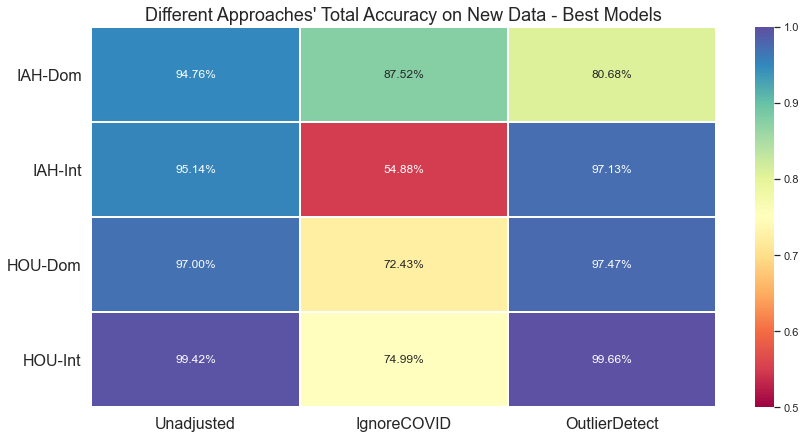

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,96.58%,72.46%,93.74%


In [5]:
display_results_hm(best_models_results[0])

### mean accuracy (1-mape)

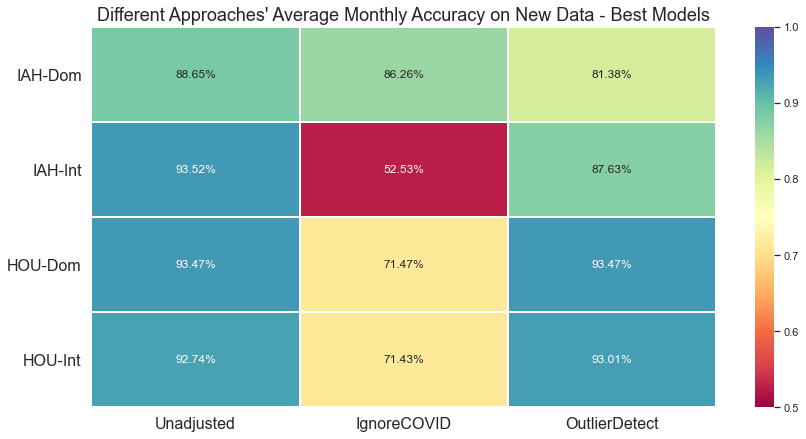

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,92.09%,70.42%,88.87%


In [6]:
mean_results = compare_all_models(series_map,accuracy='mean')
display_results_hm(mean_results[0],'Average Monthly')

## Compare all ARIMA models

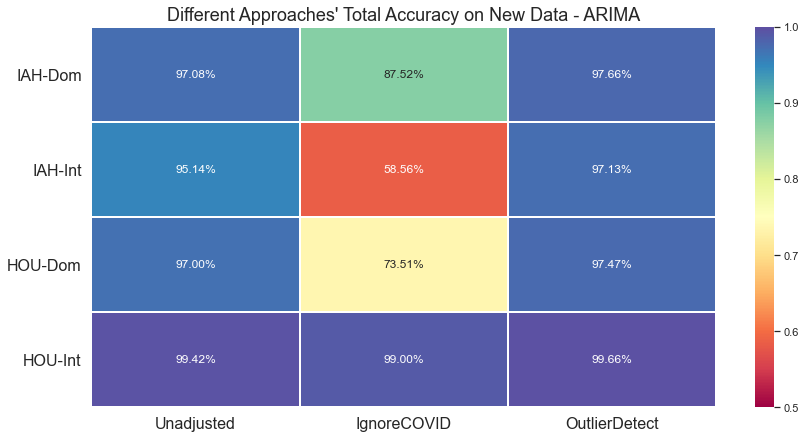

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,97.16%,79.65%,97.98%


In [7]:
arima_results = compare_all_models(series_map,models='arima')
display_results_hm(arima_results,models='ARIMA')

## Compare all Prophet models

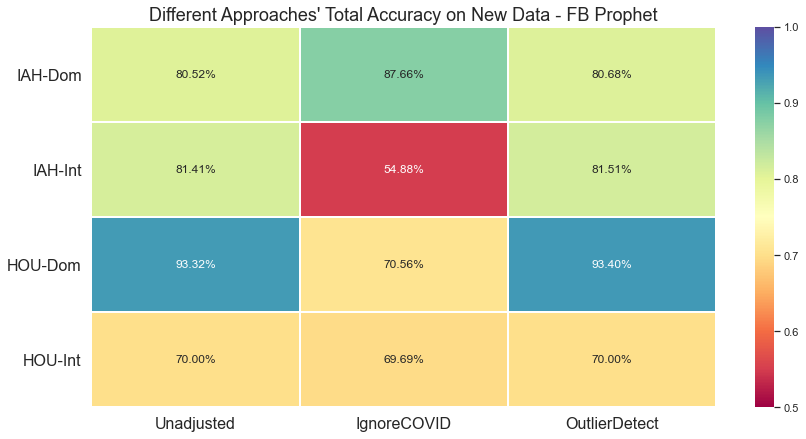

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,81.31%,70.70%,81.40%


In [8]:
prophet_results = compare_all_models(series_map,models='prophet')
display_results_hm(prophet_results,models='FB Prophet')

## Compare all LSTM models

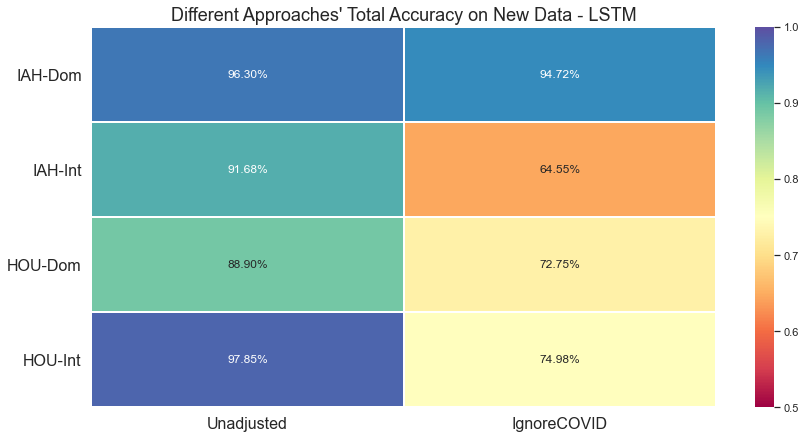

,Unadjusted,IgnoreCOVID
Grand Mean,93.68%,76.75%


In [9]:
lstm_results = compare_all_models(series_map,models='lstm')
display_results_hm(lstm_results,models='LSTM')

## Compare all regularized LSTM models

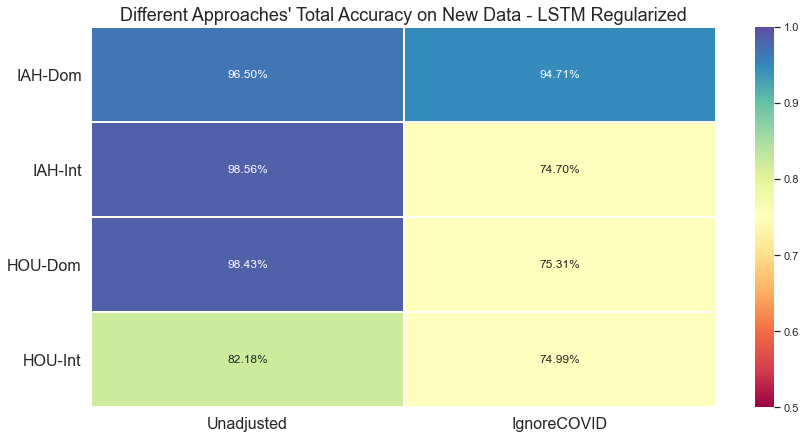

,Unadjusted,IgnoreCOVID
Grand Mean,93.92%,79.93%


In [10]:
lstm_reg_results = compare_all_models(series_map,models='lstm_reg')
display_results_hm(lstm_reg_results,models='LSTM Regularized')

## Compare all Ensemble models

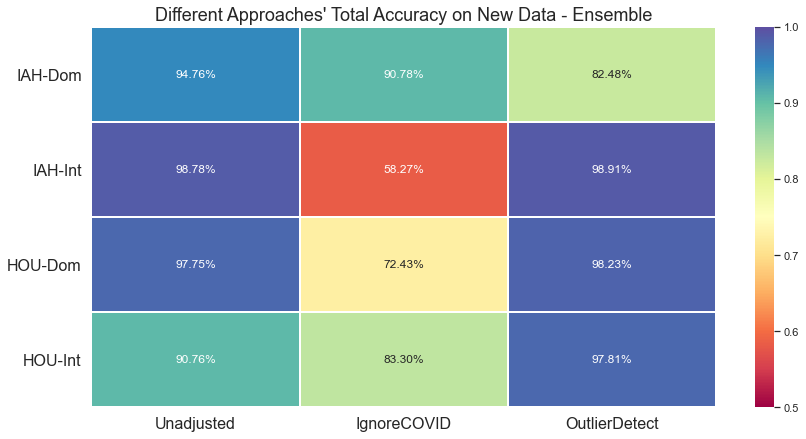

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,95.51%,76.20%,94.36%


In [11]:
ens_results = compare_all_models(series_map,models='weighted_ensemble')
display_results_hm(ens_results,models='Ensemble')